# Diffusion Model

## Dataset

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

# def show_images(dataset, num_samples = 20, cols = 4):
#   """
#   Plots some samples from the dataset
#   """
#   plt.figure(figsize=(15,15))
#   for i, img in enumerate(dataset):
#     if i == num_samples:
#       break
#     plt.subplot(num_samples//cols + 1, cols, i+1)
#     plt.imshow(img[0])

# data = torchvision.datasets.StanfordCars(root = ".", download = True)
# show_images(data)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

data/contrast-00000-of-00001.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

data/gaussian_noise-00000-of-00002.parqu(…):   0%|          | 0.00/475M [00:00<?, ?B/s]

data/gaussian_noise-00001-of-00002.parqu(…):   0%|          | 0.00/450M [00:00<?, ?B/s]

data/impulse_noise-00000-of-00002.parque(…):   0%|          | 0.00/543M [00:00<?, ?B/s]

data/impulse_noise-00001-of-00002.parque(…):   0%|          | 0.00/513M [00:00<?, ?B/s]

data/jpeg_compression-00000-of-00001.par(…):   0%|          | 0.00/467M [00:00<?, ?B/s]

data/motion_blur-00000-of-00001.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

data/pixelate-00000-of-00001.parquet:   0%|          | 0.00/3.74M [00:00<?, ?B/s]

data/spatter-00000-of-00002.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

data/spatter-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8144 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating contrast split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating gaussian_noise split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating impulse_noise split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating jpeg_compression split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating motion_blur split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating pixelate split:   0%|          | 0/8041 [00:00<?, ? examples/s]

Generating spatter split:   0%|          | 0/8041 [00:00<?, ? examples/s]

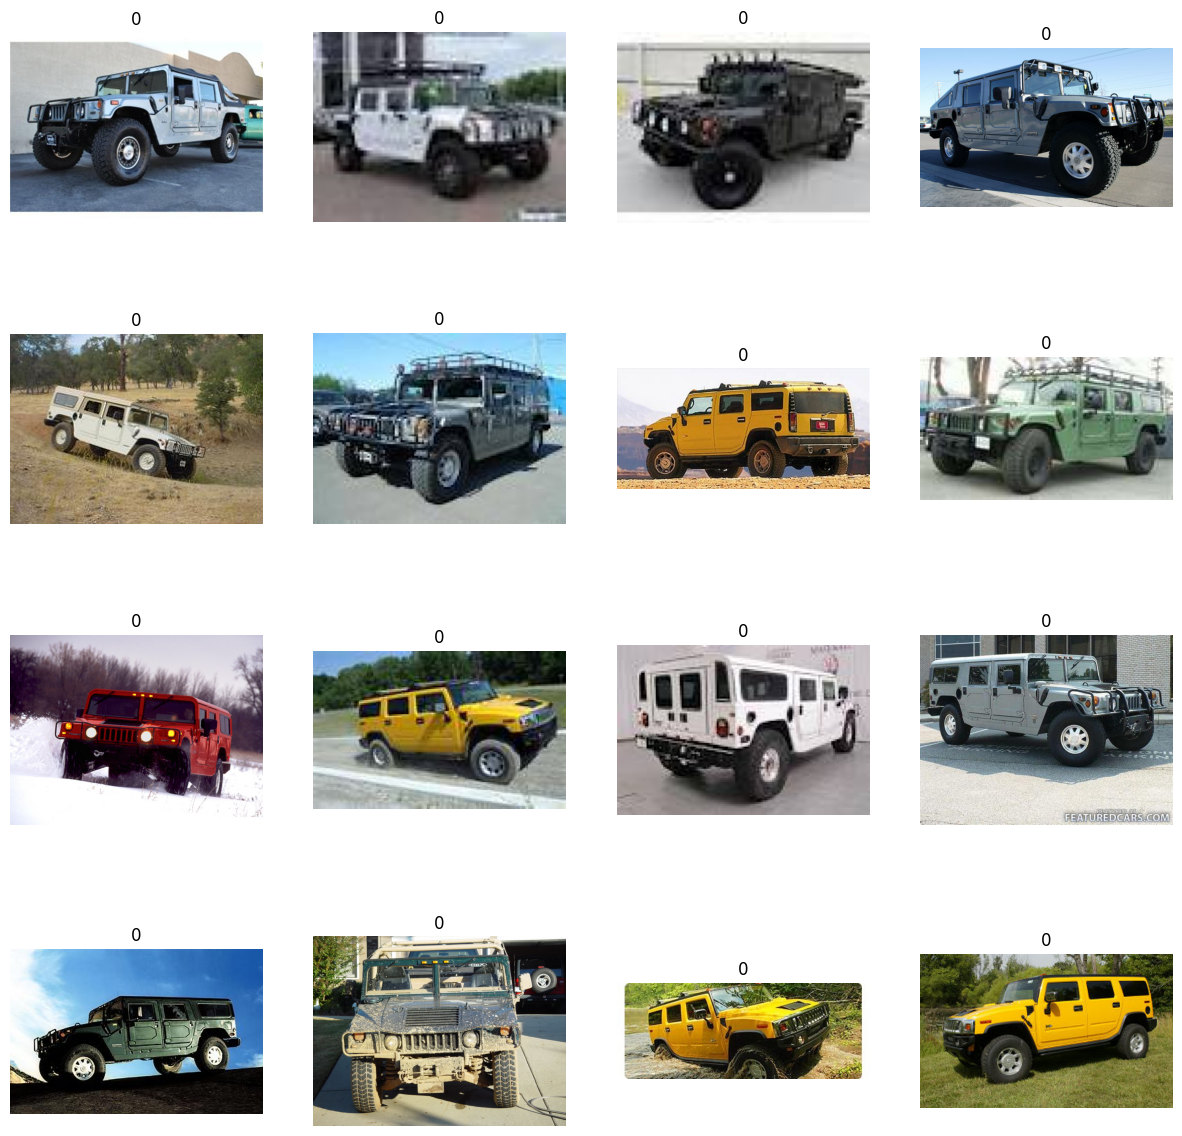

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

# Example: Stanford Cars (mirror on HF)
ds = load_dataset("tanganke/stanford_cars")

train = ds["train"]

def show_images_from_hf(hf_dataset, num_samples=20, cols=4):
    rows = num_samples // cols + int(num_samples % cols != 0)
    plt.figure(figsize=(15, 15))
    for i in range(min(num_samples, len(hf_dataset))):
        img = hf_dataset[i]["image"]         # this is a PIL Image
        label = hf_dataset[i].get("label", "")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.asarray(img))
        plt.title(str(label))
        plt.axis("off")
    plt.show()

show_images_from_hf(train, num_samples=16, cols=4)


## Building the Diffusion Model

### Step 1 : The forwared Process = Noise Schduler
First we need to build inputs for our model, which are noisy images. instead of doing this sequentially or linearly, we can use the closed form provided in the papers to calculate the image for any of the timesteps.
- variance is pre defined
- there are different types of variance schedules
- no model is needed in this forward step

In [20]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
  return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
  """
  Returns a specific index t of a passed list of values vals
  while considering the batch dimension.
  """
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device = "cpu"):
  """
  Takes an image and a timestep as input  and returns the noisy version
  """
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumprod_t = get_index_from_list(
      sqrt_alphas_cumprod,
      t,
      x_0.shape
      )
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod,
      t,
      x_0.shape
  )
  # Mean + Variance
  return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
  + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps = T)

# Pre calculated, different terms for lcosed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1)
sqrt_recip_alphas = torch.sqrt(1. / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [4]:
# from torchvision import transforms
# from torch.utils.data import DataLoader
# import numpy as np

# IMG_SIZE = 64
# BATCH_SIZE = 128

# def load_transformed_dataset():
#   data_transform = transforms.Compose([
#       transforms.Resize((IMG_SIZE, IMG_SIZE)),
#       transforms.RandomHorizontalFlip(),
#       transforms.ToTensor(), # Scales data into [0,1]
#       transforms.Lambda(lambda t: (t * 2) - 1) # Scales data into [1,-1]
#   ])
#   train = load_dataset("tanganke/stanford_cars", split = "train")

#   test = load_dataset("tanganke/stanford_cars", split = "test")

In [5]:
# import torch
# from torch.utils.data import ConcatDataset
# from torchvision import datasets, transforms

# IMG_SIZE = 64  # or any size you want

# def load_transformed_dataset():
#     data_transform = transforms.Compose([
#         transforms.Resize((IMG_SIZE, IMG_SIZE)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),                     # Scales to [0,1]
#         transforms.Lambda(lambda t: (t * 2) - 1)   # Scales to [-1,1]
#     ])

#     # Load both train and test sets
#     train = datasets.StanfordCars(
#         root=".",
#         split="train",
#         download=True,
#         transform=data_transform
#     )

#     test = datasets.StanfordCars(
#         root=".",
#         split="test",
#         download=True,
#         transform=data_transform
#     )

#     # Combine them into one dataset
#     full_dataset = ConcatDataset([train, test])
#     return full_dataset


In [21]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from torchvision import transforms
from PIL import Image

IMG_SIZE = 64  # You can change this as needed
BATCH_SIZE = 128

def load_transformed_dataset(ds):
    """
    Takes a Hugging Face dataset (with 'train' and 'test' splits),
    applies transforms, and returns a concatenated PyTorch dataset.
    """

    # Define transforms
    data_transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                   # [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1) # [-1, 1]
    ])

    # Custom wrapper to apply transforms
    class HFDataset(Dataset):
        def __init__(self, hf_data, transform=None):
            self.data = hf_data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            item = self.data[idx]
            image = item["image"]
            label = item.get("label", -1)

            if not isinstance(image, Image.Image):
                image = Image.fromarray(image)

            if self.transform:
                image = self.transform(image)
            return image, label

    # Apply to both splits
    train_dataset = HFDataset(ds["train"], transform=data_transform)
    test_dataset = HFDataset(ds["test"], transform=data_transform)

    # Concatenate
    full_dataset = ConcatDataset([train_dataset, test_dataset])

    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")
    print(f"Total samples: {len(full_dataset)}")

    return full_dataset

In [22]:
from torch.utils.data import DataLoader

def show_tensor_image(image):
  reverse_transform = transforms.Compose([
      transforms.Lambda(lambda t: (t+1) / 2),
      transforms.Lambda(lambda t: t.permute(1,2,0)), # CHW TO HWC
      transforms.Lambda(lambda t: t* 255),
      transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
      transforms.ToPILImage(),
  ])

  if len(image.shape) == 4:
    image = image[0, :, :, :]
  plt.imshow(reverse_transform(image))

data = load_transformed_dataset(ds)
dataloader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

Train samples: 8144
Test samples:  8041
Total samples: 16185


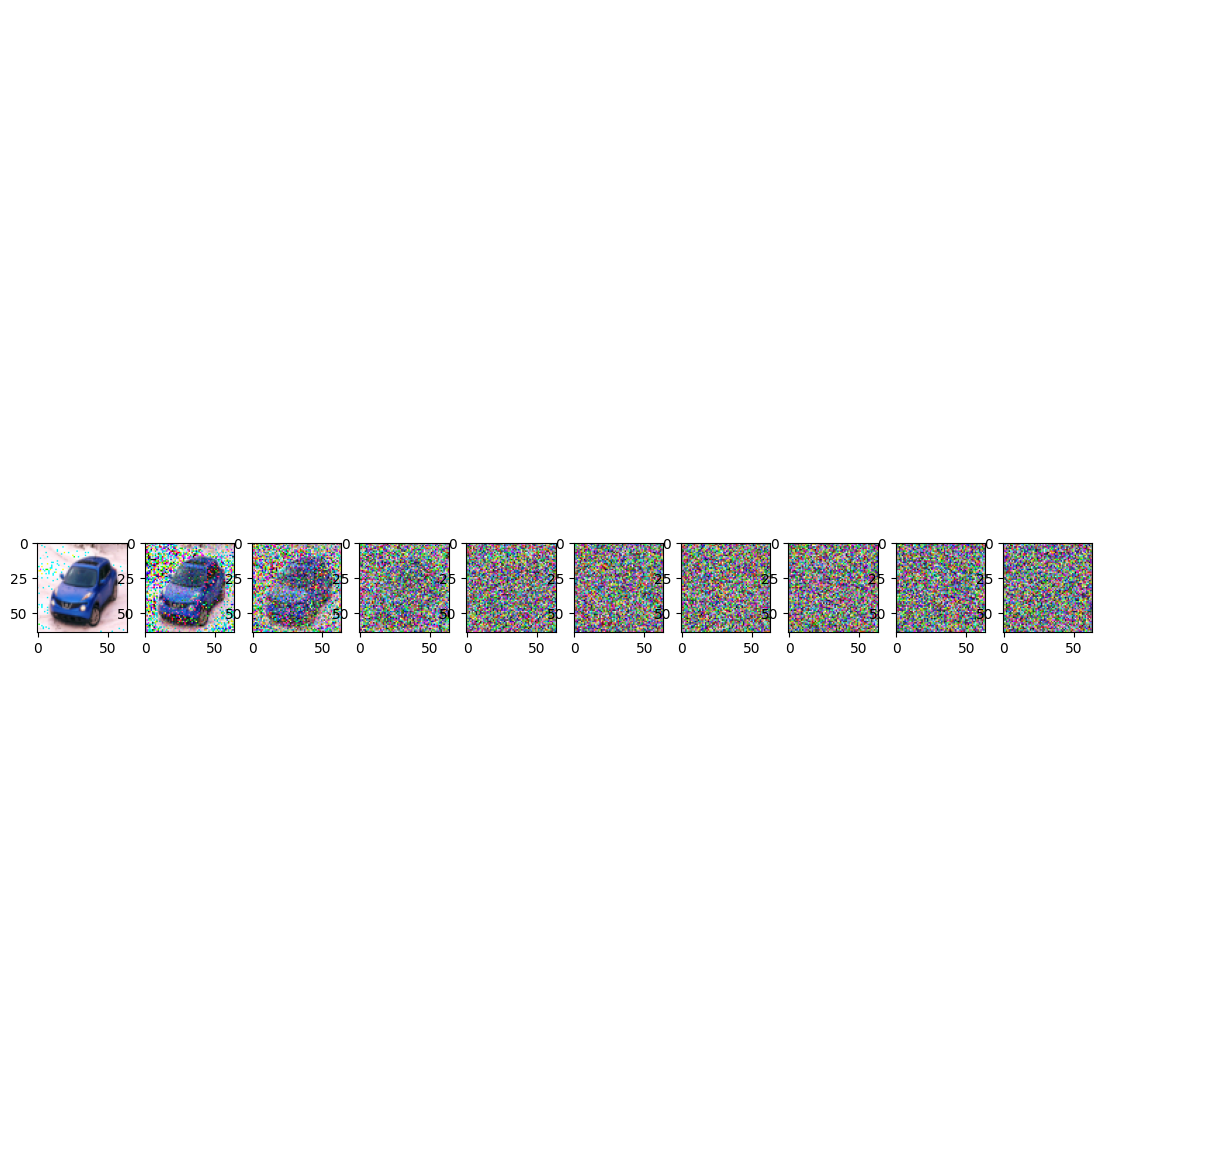

In [23]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
  t = torch.tensor([idx]).type(torch.int64)
  plt.subplot(1, num_images+1, idx//stepsize+1)
  image, noise = forward_diffusion_sample(image, t)
  show_tensor_image(image)

### Step 2 : The backward process = U-Net
Takeaways:
- We use a simple UNet to predict the noise in the image
- The input is a noisy image, the output is the noise in the image
- Because the parameters are shared across time, we need to tell the network in which time step we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one singe value(mean), because the variance is fixed

In [24]:
from torch import nn
import math

class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up = False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)
    if up:
      self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding = 1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
      self.transform = nn.Conv2d(out_ch,out_ch, 4, 2 , 1)
    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
    self.bnorm = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU()

  def forward(self, x, t):
    # First Conv
    h = self.bnorm(self.relu(self.conv1(x)))
    # Time embedding
    time_emb = self.relu(self.time_mlp(t))
    # Extend Last 2 dimensions
    time_emb = time_emb[(..., )+ (None, ) * 2]
    # Add time channel
    h = h + time_emb
    # Second Conv
    h = self.bnorm(self.relu(self.conv2(h)))
    # Donw or Upsample
    return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device = device)* -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim = -1)
    return embeddings

class SimpleUnet(nn.Module):
  """
  A simplified variant of the Unet architecture.
  """
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)
    out_dim = 1
    time_emb_dim = 32

    # Time embedding
    self.time_mlp = nn.Sequential(
        SinusoidalPositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )
    # Initial projection
    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding = 1)
    # DownSample
    self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1],
                                      time_emb_dim)
                                for i in range(len(down_channels)-1)])
    # UpSample
    self.ups = nn.ModuleList([Block(up_channels[i],
                                    up_channels[i+1],
                                    time_emb_dim, up =True)
                                    for i in range(len(up_channels)-1)])
    self.output = nn.Conv2d(up_channels[-1], 3, out_dim)


  def forward(self, x, timestep):
    # Embedd time
    t = self.time_mlp(timestep)
    # Initial Conv
    x = self.conv0(x)
    # Unet
    residual_inputs = []
    for down in self.downs:
      x = down(x, t)
      residual_inputs.append(x)
    for up in self.ups:
      residual_x = residual_inputs.pop()
      # Add residual x as additional channels
      x = torch.cat((x, residual_x), dim = 1)
      x = up(x, t)
    return self.output(x)

model = SimpleUnet()
print("Num params : ", sum(p.numel() for p in model.parameters()))
model


Num params :  62433123


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256,

### Step 3 : The loss

In [25]:
def get_loss(model, x_0, t):
  x_noisy, noise = forward_diffusion_sample(x_0, t, device=device)
  noise_pred = model(x_noisy, t)
  return F.l1_loss(noise, noise_pred)

## Sampling

In [35]:
@torch.no_grad()
def sample_timestep(x, t):
  """
  Calls the model to predict the noise in the image and returns
  the denoised image
  """
  betas_t = get_index_from_list(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x.shape)
  sqrt_recip_alphas_t = get_index_from_list(
      sqrt_recip_alphas, t, x.shape)

  # Call model (current image - noise prediction)
  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
  )
  posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

  if t ==0:
    return model_mean
  else:
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    num_images = 10
    stepsize = int(T / num_images)

    plt.figure(figsize=(15, 3))
    plt.axis("off")

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i // stepsize + 1)
            plt.axis("off")
            show_tensor_image(img.detach().cpu())

    # ⬇️ Small spacing added here
    plt.subplots_adjust(
        wspace=0.05,  # horizontal gap between images
        hspace=0,
        top=1, bottom=0, left=0, right=1
    )
    plt.tight_layout(pad=0.1)  # light inner padding
    plt.show()


## Training

Epoch 0 | step 000 Loss: 0.2701237201690674 


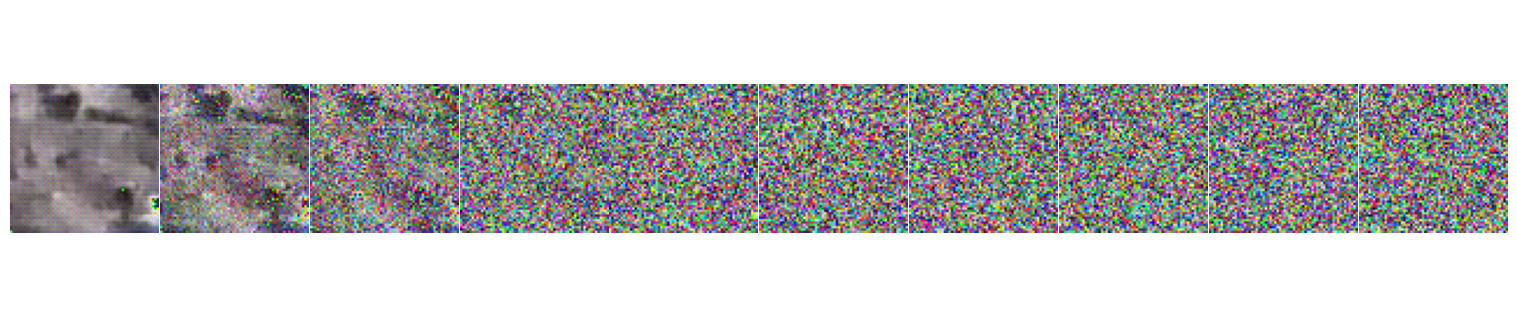

Epoch 5 | step 000 Loss: 0.15210342407226562 


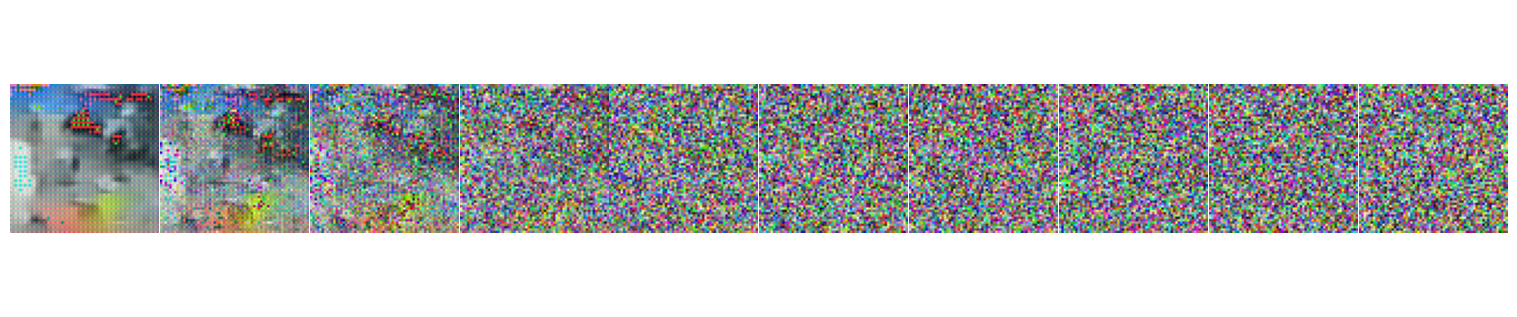

Epoch 10 | step 000 Loss: 0.15443962812423706 


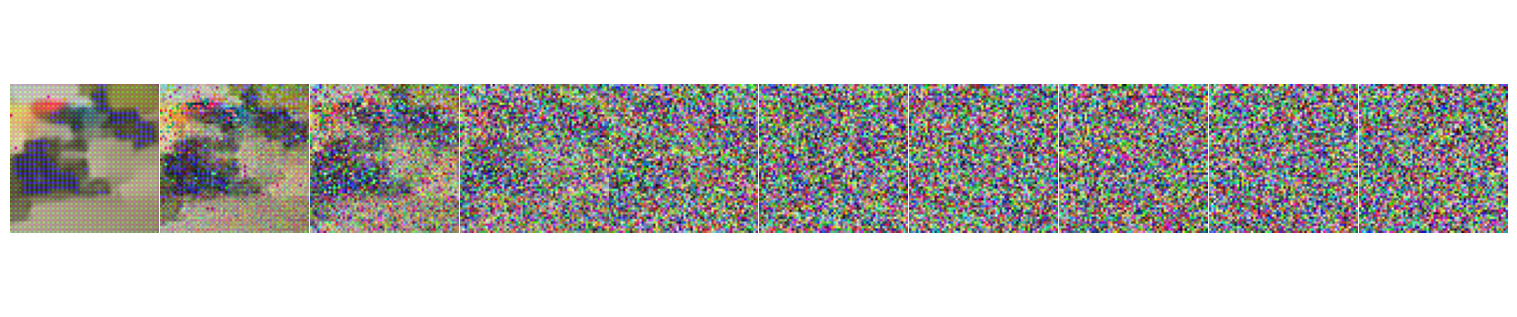

Epoch 15 | step 000 Loss: 0.14634083211421967 


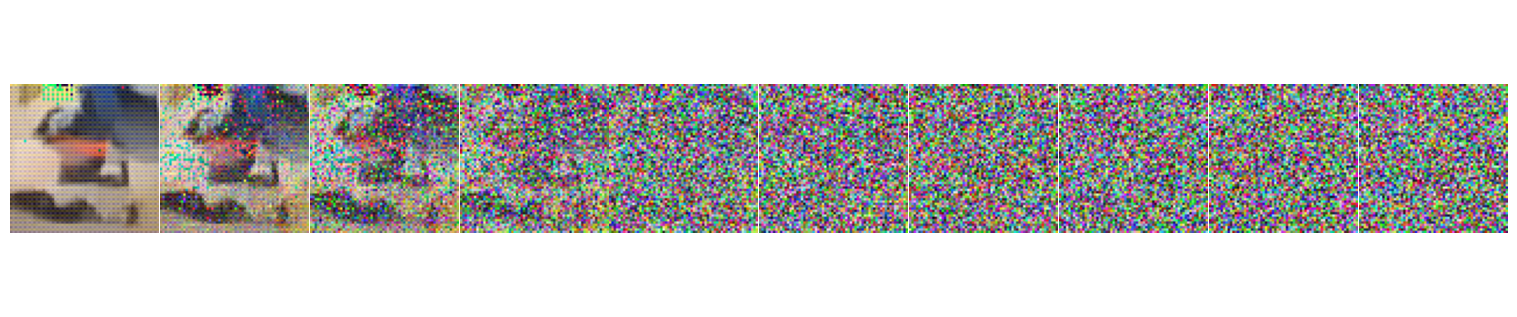

Epoch 20 | step 000 Loss: 0.13888520002365112 


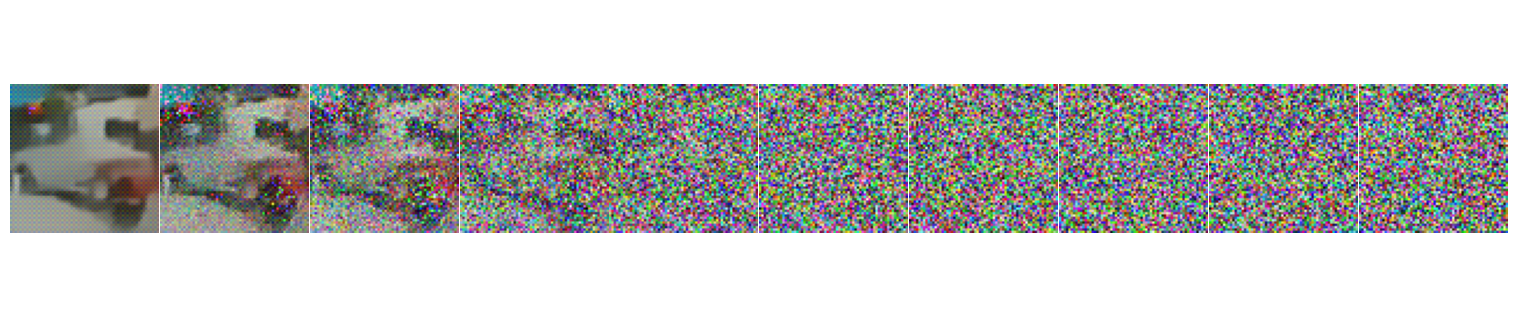

In [ ]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr = 0.001)
epochs = 100

for epoch in range(epochs):
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device = device).long()
    loss = get_loss(model, batch[0], t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image()